### Libraries

In [220]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import re
plt.style.use('seaborn-whitegrid')

### Face sleepyness

#### Code

In [23]:
def save_pic(path):
    video_capture = cv2.VideoCapture(0)
    time.sleep(3) # wait for webcam to get ready...
    _, img = video_capture.read()
    video_capture.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(path, img)

In [70]:
def face_sleepy(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes_cascade = cv2.CascadeClassifier('/Users/nkrnrnk/anaconda/lib/python3.6/site-packages/cv2/data/haarcascade_eye.xml')
    face_cascade = cv2.CascadeClassifier('/Users/nkrnrnk/anaconda/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray)
    eyes = eyes_cascade.detectMultiScale(gray)
    if len(faces) == 0:
        return False
    else:
        face = faces[0]
        f_x, f_y, f_w, f_h = face
        cnt = 0
        for (x, y, w, h) in eyes:
            if x >= f_x and y >= f_y and x+w <= f_x+f_w and y+h <= f_y+f_h:
                cnt += 1
        return {
            'face': face, 
            'eyes': eyes,
            'score': 1-min(cnt,2)/2.0,
        }

In [253]:
def face_draw(path, boxes):
    img = cv2.imread(path)
    x, y, w, h = boxes['face']
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    for (x, y, w, h) in boxes['eyes']:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), 2)
    plt.title('Sleepiness score: {}'.format(boxes['score']))
    plt.axis('off')
    plt.imshow(img)

In [242]:
awake_path = 'awake.png'
sleep_path = 'sleep.png'
half_path = 'half.png'

In [243]:
# save_pic(awake_path)

In [244]:
# save_pic(sleep_path)

In [245]:
# save_pic(half_path)

In [246]:
# face_sleepy(awake_path)

In [247]:
# face_sleepy(sleep_path)

In [248]:
# face_sleepy(half_path)

In [249]:
def face_sleepyness(path):
    return face_draw(path, face_sleepy(path))

#### Results

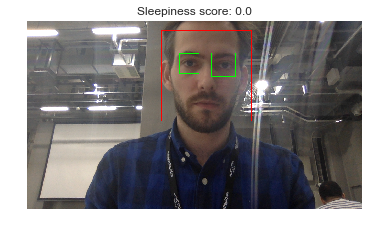

In [254]:
face_sleepyness(awake_path)

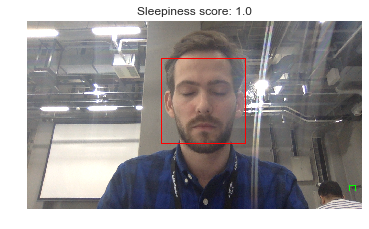

In [255]:
face_sleepyness(sleep_path)

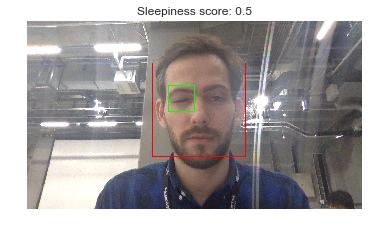

In [256]:
face_sleepyness(half_path)

### Messages sentiment

In [129]:
tweets = pd.read_csv('trump_tweets.csv', usecols=[0,1,2])

In [130]:
tweets.head()

,Date,Time,Tweet_Text
0,16-11-11,15:26:37,Today we express our deepest gratitude to all ...
1,16-11-11,13:33:35,Busy day planned in New York. Will soon be mak...
2,16-11-11,11:14:20,Love the fact that the small groups of protest...
3,16-11-11,2:19:44,Just had a very open and successful presidenti...
4,16-11-11,2:10:46,A fantastic day in D.C. Met with President Oba...


In [191]:
tweets.iloc[4].Tweet_Text

'A fantastic day in D.C. Met with President Obama for first time. Really good meeting, great chemistry. Melania liked Mrs. O a lot!'

In [194]:
def clean(s):
    return re.sub('[^0-9a-zA-Z ]+', '', str(s))

In [198]:
tweets_day = ['. '.join([clean(s) for s in data.Tweet_Text]) for d, data in tweets.groupby('Date')]

In [213]:
dates = [d for d, _ in tweets.groupby('Date')]

In [204]:
def get_sentiment(msg, i = 0):
    response = requests.post(
        'https://text-sentiment.p.rapidapi.com/analyze', 
        data = {"text": msg},
        headers = {
            "X-RapidAPI-Key": "28cdc3943amsha0898d83df6fde6p15b39djsn1114f77b0cb4",
            "Content-Type": "application/x-www-form-urlencoded"
        }
    )
    try:
        result = response.json()
    #     print(result)
        score = (result['pos']*0+result['mid']*0.5+result['neg']*1.0)/result['totalLines']
        return score
    except:
        print(i)
        return response

In [205]:
scores = []
for i, msg in tqdm(enumerate(tweets_day), total=len(tweets_day)):
    scores.append(get_sentiment(msg, i))


 32%|███▏      | 155/479 [04:55<10:27,  1.94s/it]


 65%|██████▍   | 309/479 [09:32<05:08,  1.81s/it]


 97%|█████████▋| 463/479 [14:27<00:31,  1.97s/it]


100%|██████████| 479/479 [14:57<00:00,  1.92s/it]


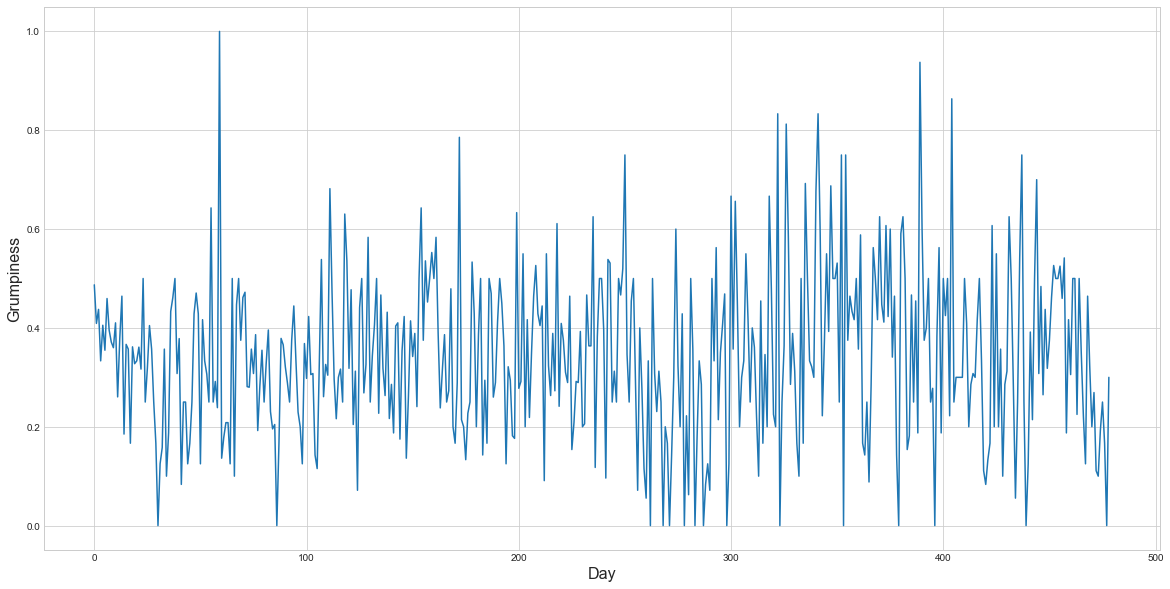

In [240]:
plt.figure(figsize=(20,10))
plt.xlabel('Day', fontsize=16)
plt.ylabel('Grumpiness', fontsize=16)
plt.plot(list(range(len(scores))), scores)

In [238]:
df = pd.DataFrame.from_dict({'date': dates, 'score': scores})
df.to_csv('trump_tweet_sentiments.csv')

In [230]:
df[df.score>0.9]

,date,score
59,15-09-13,1.0000
389,16-08-14,0.9375


In [234]:
tweets[tweets.Date=='15-09-13'].Tweet_Text.values

array(['Why is someone like George Pataki, who did a terrible job as Governor of N.Y. and registers ZERO in the polls, allowed on the debate stage?'],
      dtype=object)

In [235]:
tweets[tweets.Date=='16-08-14'].Tweet_Text.values

array(['I have always been the same person-remain true to self.The media wants me to change but it would be very dishonest to supporters to do so!',
       'It is not "freedom of the press" when newspapers and others are allowed to say and write whatever they want even if it is completely false!',
       'I am not only fighting Crooked Hillary, I am fighting the dishonest and corrupt media and her government protection process. People get it!',
       'Crooked Hillary Clinton is being protected by the media. She is not a talented person or politician. The dishonest media refuses to expose!',
       'My rallies are not covered properly by the media. They never discuss the real message and never show crowd size or enthusiasm.',
       'If the disgusting and corrupt media covered me honestly and didnt put false meaning into the words I say, I would be beating Hillary by 20%',
       'The failing @nytimes, which never spoke to me, keeps saying that I am saying to advisers that I will chang

In [236]:
df[df.score<0.1]

,date,score
30,15-08-15,0.000000
41,15-08-26,0.083333
86,15-10-11,0.000000
124,15-11-18,0.071429
212,16-02-16,0.090909
241,16-03-16,0.096154
256,16-03-31,0.071429
260,16-04-04,0.055556
262,16-04-06,0.000000
268,16-04-12,0.000000


In [237]:
tweets[tweets.Date=='16-09-28'].Tweet_Text.values

array(['Join me live in Waukesha, Wisconsin for an 8pmE rally! #AmericaFirst #MAGA\nhttps://t.co/G8kGLSFy6S',
       'Thank you Council Bluffs, Iowa! Will be back soon. Remember- everything you need to know about Hillary -- just_ https://t.co/45kIHxdX83',
       'RT @TeamTrump: "She put the office of Sec of State up for sale. If she ever got the chance, she۪d put the Oval Office up for sale too." #Fo_',
       'An honor to meet with the Polish American Congress in Chicago this morning! #ImWithYou\nVideo:_ https://t.co/lBFHoWRqox',
       'Melania and I extend our deepest condolences to the family of Shimon Peres...https://t.co/xeGYL2IzUP',
       'Join me in Council Bluffs, Iowa- today at 3pm! #MakeAmericaGreatAgain\nTickets: https://t.co/iRL3xh37gF',
       'Every on-line poll, Time Magazine, Drudge etc., has me winning the debate. Thank you to Fox &amp; Friends for so reporting!',
       'My supporters are the best! $18 million from hard-working people who KNOW what we can be again! 